## Question 2

### Describtion :
با توجه به آنکه این سوال را قبلا ران کرده بودیم و نتایج و عکس ها را ذخیره کرده بودیم اما فایل نوت بوک را سیو نکرده بودیم، دوباره مجبور شدیم که کد را ران کنیم. اما با توجه به کم شدن یهویی سرعت کولب در شب تحویل و مشکلی که صبح پیش آمد و به علت کمبود تایم، نتوانستیم که کد را به ازای 100 ایپاک ران کنیم و به همین دلیل ان را به ازای 50 ایپاک ران کرده ایم 

### code describtion :

ورودی این شبکه نویز است و از طریق دستور  زیر اعداد تصادفی را به عنوان نویز دریافت می کند

init = initializers.RandomNormal(stddev=0.02) 

عکس های دیتاست را بین [1,-1] قرار می دهیم

in generator :
use the inverse of convolution,called transposed convolution- RELU activation and BathNormalization – The input to the generator is the normal distribution z or latent sample – the last activation is tanh

in discriminator :
Use the Cinvolutional neural network-LeaklyReLU activation and BathNormalization-the last activation is sigmoid

loss fn is binary_crossentropy 
optimizer is Adam(lr=0.0003,baeta_1=0.5
batch size=64

In [ ]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from keras.layers import GaussianNoise

In [ ]:
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LeakyReLU, BatchNormalization, ReLU
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.optimizers import Adam
from keras import initializers
from keras.utils import plot_model, np_utils
from keras import backend as K

Using TensorFlow backend.


In [ ]:
# load dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


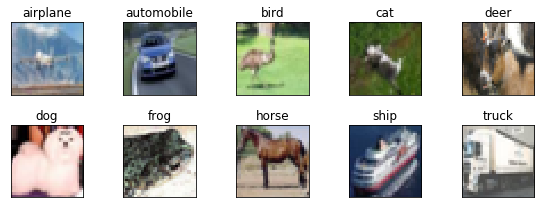

In [ ]:
num_classes = len(np.unique(y_train))
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = X_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    img = features_idx[img_num,::]
    ax.set_title(class_names[i])
    plt.imshow(img)
    
plt.tight_layout()

In [ ]:
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [ ]:
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, 32, 32)
    X_test = X_test.reshape(X_test.shape[0], 3, 32, 32)
    input_shape = (3, 32, 32)
else:
    X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
    X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
    input_shape = (32, 32, 3)
    
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

# the generator is using tanh activation, for which we need to preprocess 
# the image data into the range between -1 and 1.

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

X_test = np.float32(X_test)
X_test = (X_train / 255 - 0.5) * 2
X_test = np.clip(X_test, -1, 1)

print('X_train reshape:', X_train.shape)
print('X_test reshape:', X_test.shape)

X_train reshape: (50000, 32, 32, 3)
X_test reshape: (50000, 32, 32, 3)


In [ ]:
# latent space dimension
latent_dim = 100

init = initializers.RandomNormal(stddev=0.02)

# Generator network
generator = Sequential()

# FC: 2x2x512
generator.add(Dense(2*2*512, input_shape=(latent_dim,), kernel_initializer=init))
generator.add(Reshape((2, 2, 512)))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# # Conv 1: 4x4x256
generator.add(Conv2DTranspose(256, kernel_size=5, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# Conv 2: 8x8x128
generator.add(Conv2DTranspose(128, kernel_size=5, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# Conv 3: 16x16x64
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# Conv 4: 32x32x3
generator.add(Conv2DTranspose(3, kernel_size=5, strides=2, padding='same',
                              activation='tanh'))

In [ ]:
# prints a summary representation of your model
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2048)              206848    
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 2, 512)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 2, 512)         2048      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 2, 2, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 4, 4, 256)         3277056   
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 4, 4, 256)        

In [ ]:
# imagem shape 32x32x3
img_shape = X_train[0].shape

# Discriminator network
discriminator = Sequential()

# Conv 1: 16x16x64
discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding='same',
                         input_shape=(img_shape), kernel_initializer=init))
discriminator.add(LeakyReLU(0.2))

# Conv 2:
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

# Conv 3: 
discriminator.add(Conv2D(256, kernel_size=5, strides=2, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

# Conv 3: 
discriminator.add(Conv2D(512, kernel_size=5, strides=2, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

# FC
discriminator.add(Flatten())

# Output
discriminator.add(Dense(1, activation='sigmoid'))

In [ ]:
# prints a summary representation of your model
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
batch_normalization_6 (Batch (None, 4, 4, 256)        

In [ ]:
# Optimizer

history1 = discriminator.compile(Adam(lr=0.0003, beta_1=0.5), loss='binary_crossentropy',
                      metrics=['binary_accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
# d_g = discriminador(generador(z))
discriminator.trainable = False

z = Input(shape=(latent_dim,))
img = generator(z)
decision = discriminator(img)
d_g = Model(inputs=z, outputs=decision)

history2 = d_g.compile(Adam(lr=0.0004, beta_1=0.5), loss='binary_crossentropy',
            metrics=['binary_accuracy'])

In [ ]:
# prints a summary representation of your model
d_g.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32, 3)         4516739   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 4312193   
Total params: 8,828,932
Trainable params: 4,514,819
Non-trainable params: 4,314,113
_________________________________________________________________


In [ ]:
def vis_square(data, padsize=1, padval=0):
  # force the number of filters to be square
  n = int(np.ceil(np.sqrt(data.shape[0])))
  padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
  data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))

  # tile the filters into an image
  data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
  data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
  return data



epoch = 1/50, d_loss=0.008, g_loss=0.020                                                                                                     


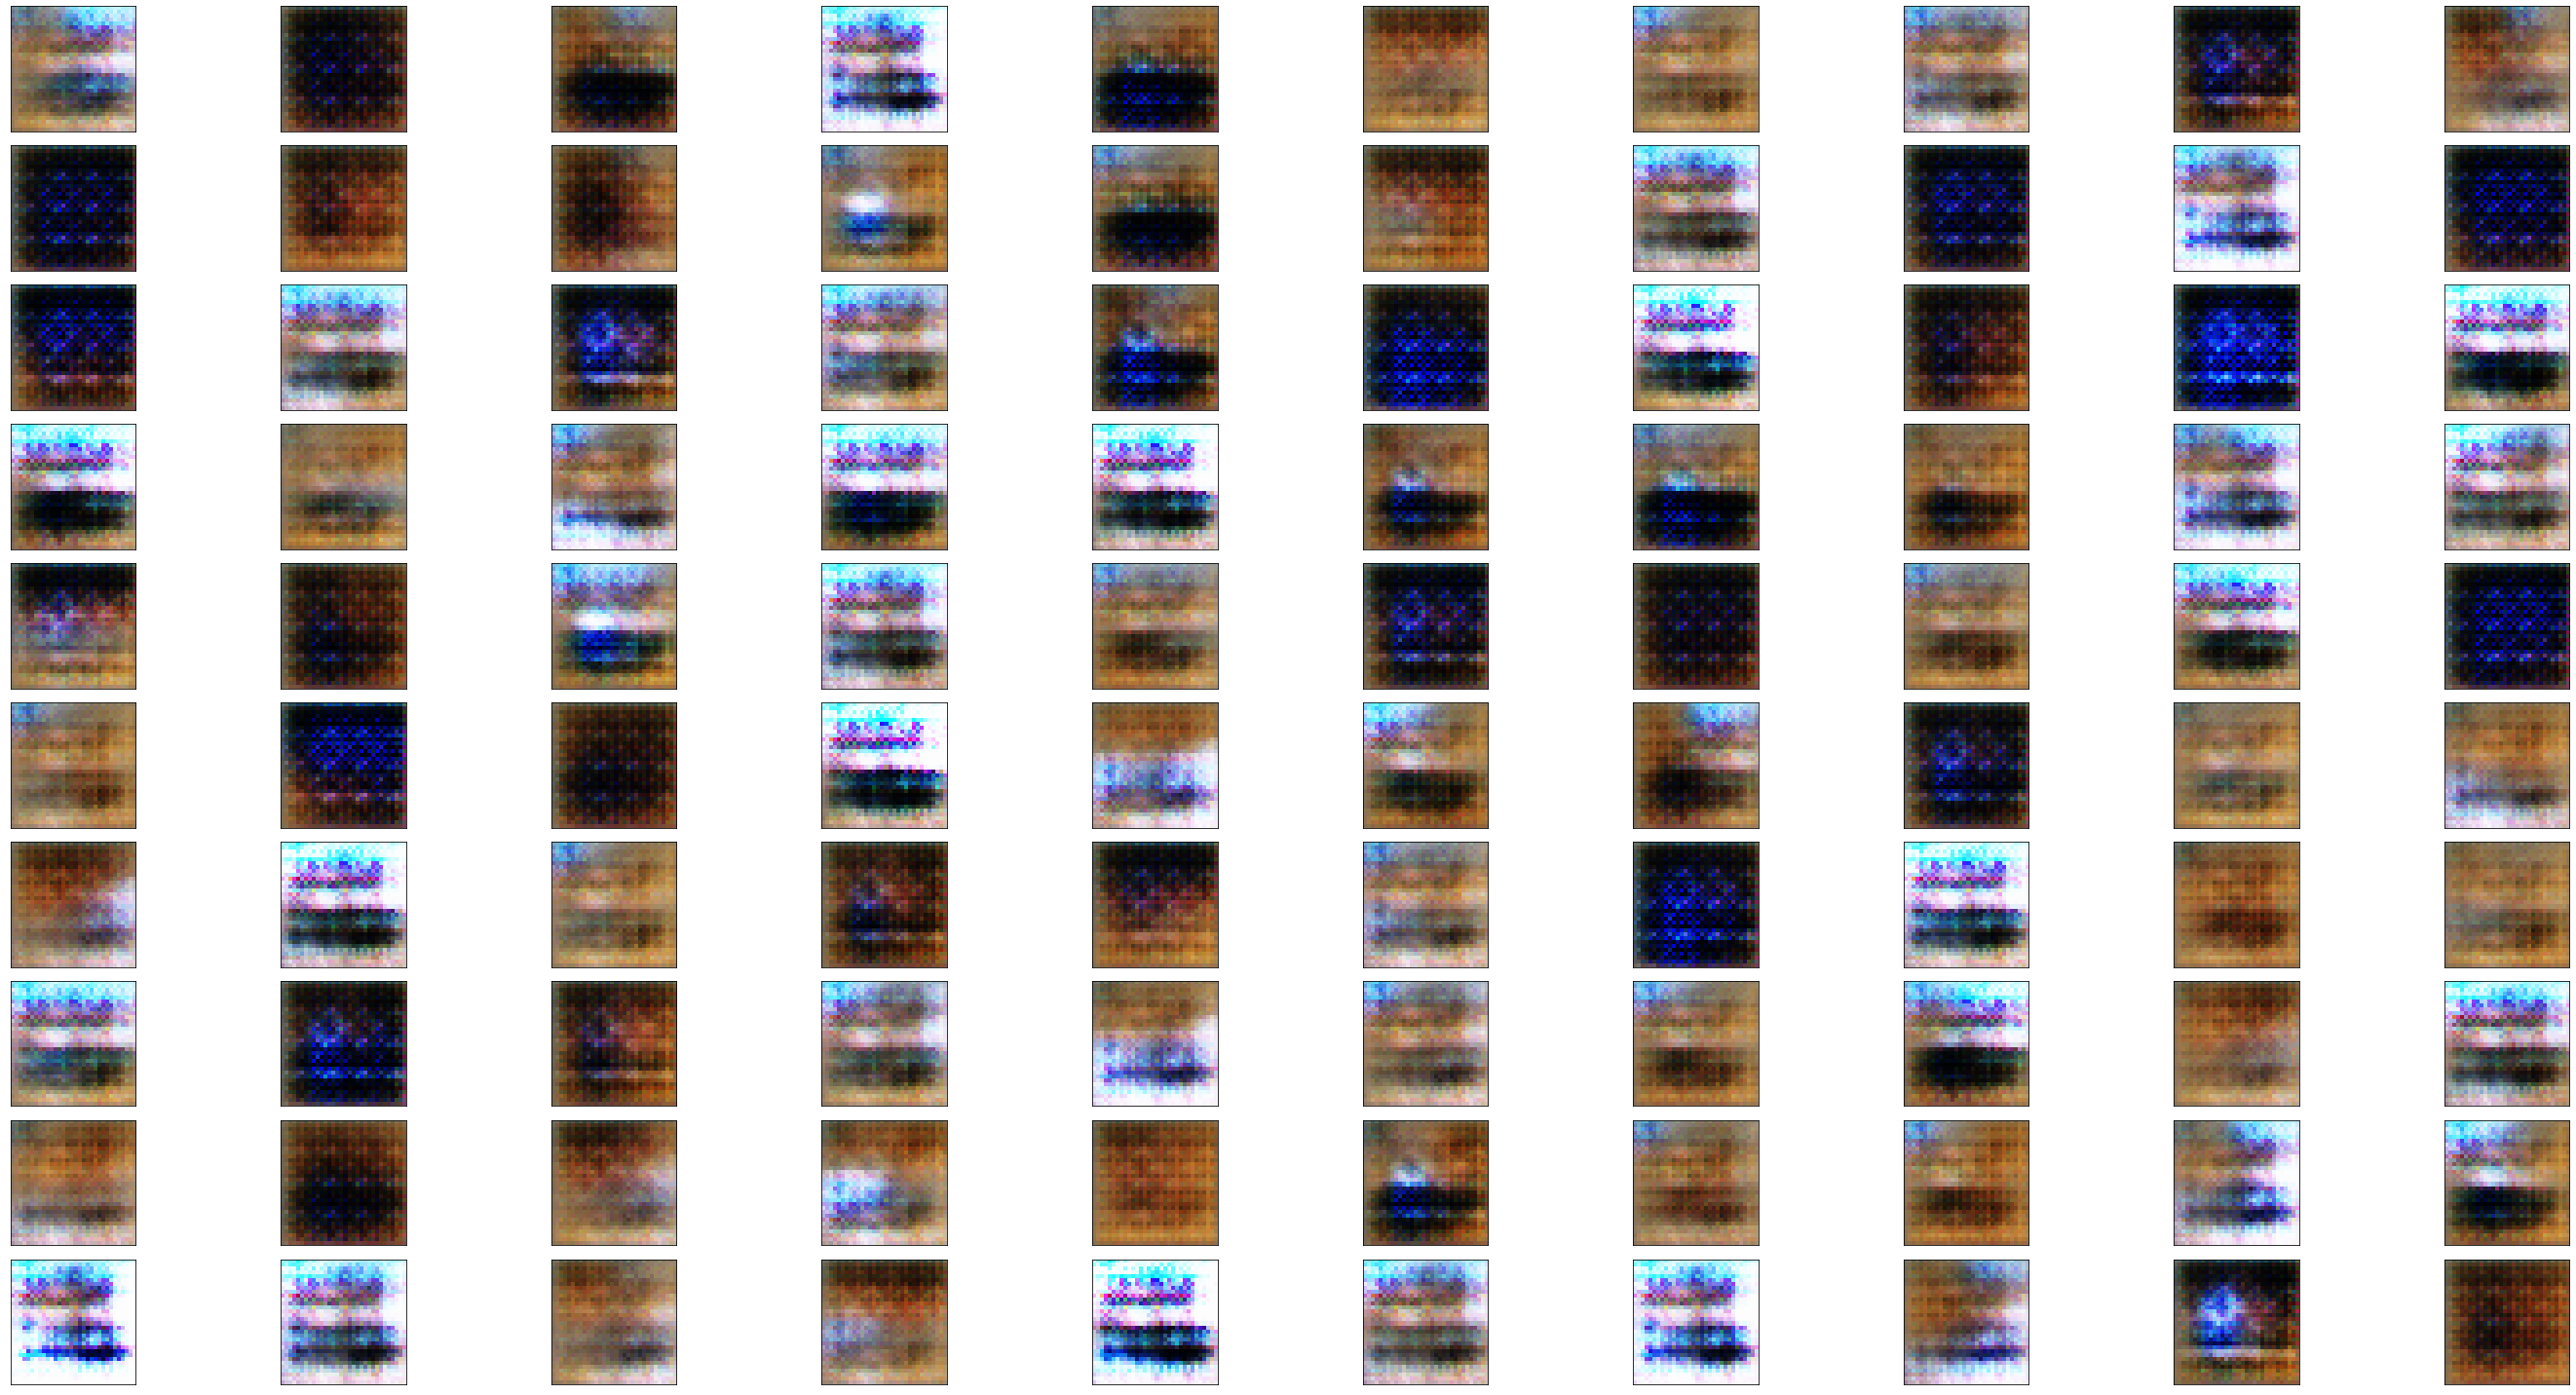

epoch = 2/50, d_loss=1.124, g_loss=1.282                                                                                                     
epoch = 3/50, d_loss=0.617, g_loss=5.405                                                                                                     
epoch = 4/50, d_loss=0.068, g_loss=4.182                                                                                                     
epoch = 5/50, d_loss=0.342, g_loss=5.141                                                                                                     
epoch = 6/50, d_loss=0.577, g_loss=7.439                                                                                                     
epoch = 7/50, d_loss=0.434, g_loss=7.867                                                                                                     
epoch = 8/50, d_loss=0.005, g_loss=4.569                                                                                                     
epoch 

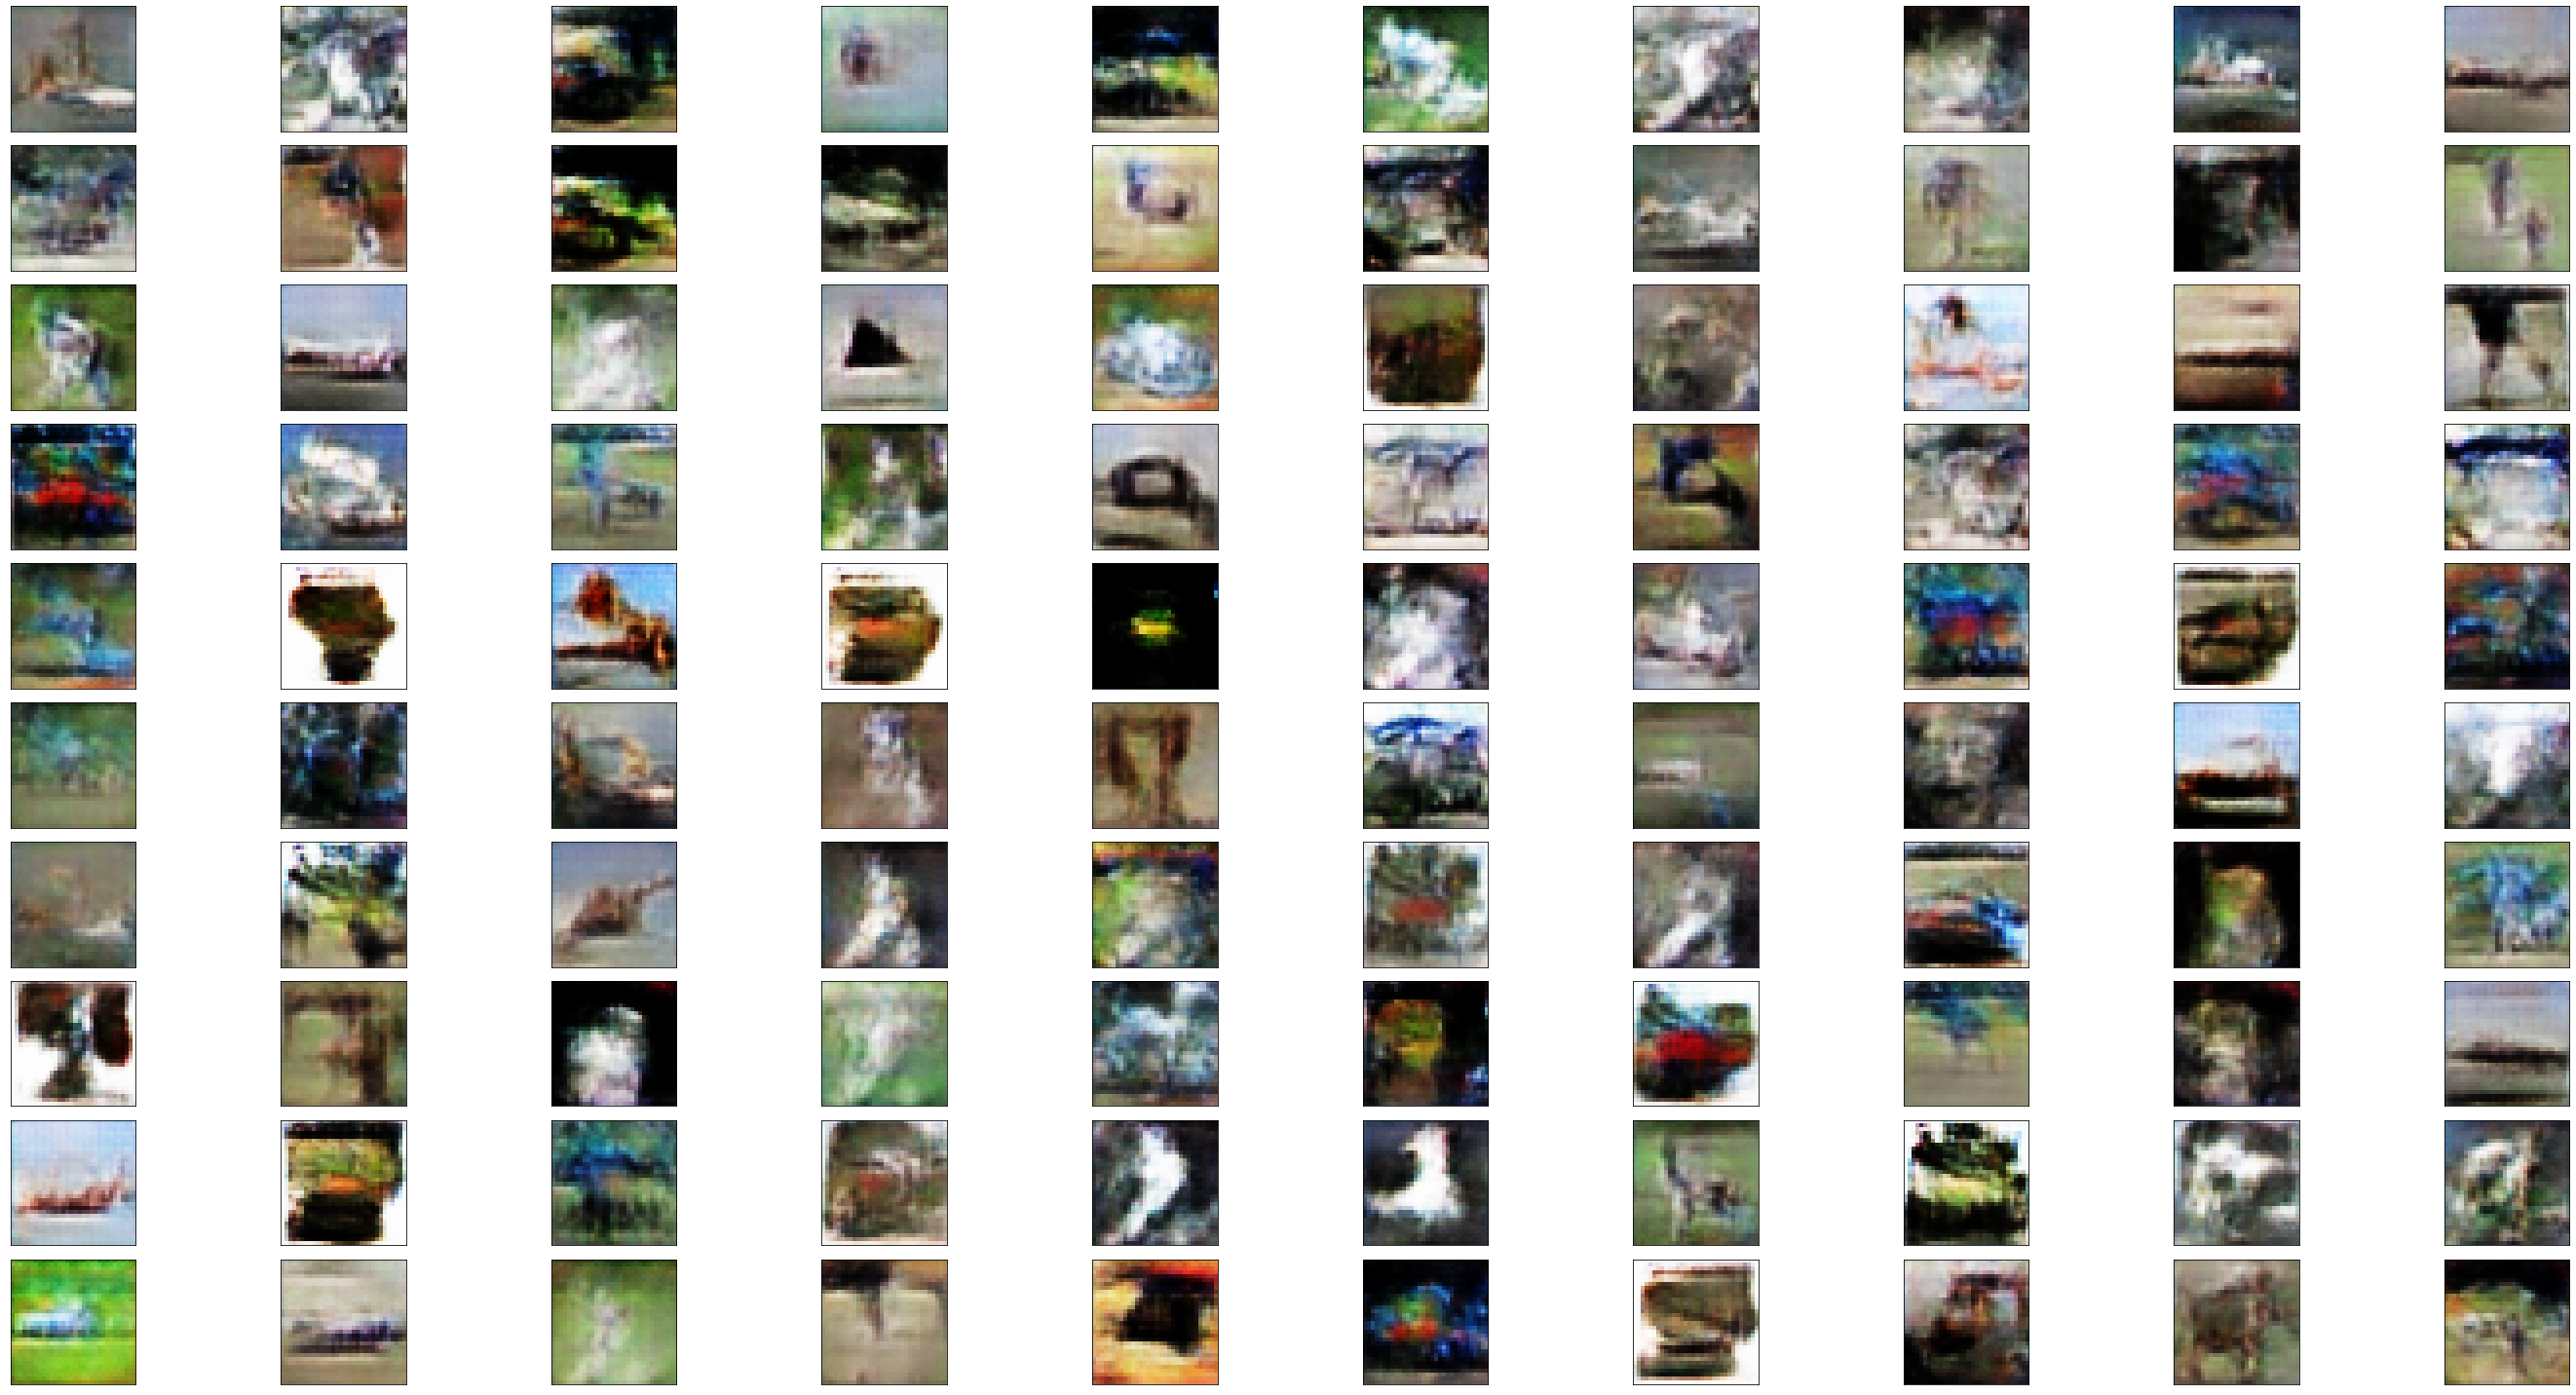

epoch = 12/50, d_loss=0.032, g_loss=3.997                                                                                                     
epoch = 13/50, d_loss=0.129, g_loss=3.325                                                                                                     
epoch = 14/50, d_loss=0.276, g_loss=5.909                                                                                                     
epoch = 15/50, d_loss=0.062, g_loss=5.064                                                                                                     
epoch = 16/50, d_loss=0.243, g_loss=4.462                                                                                                     
epoch = 17/50, d_loss=0.396, g_loss=6.940                                                                                                     
epoch = 18/50, d_loss=0.124, g_loss=3.768                                                                                                     

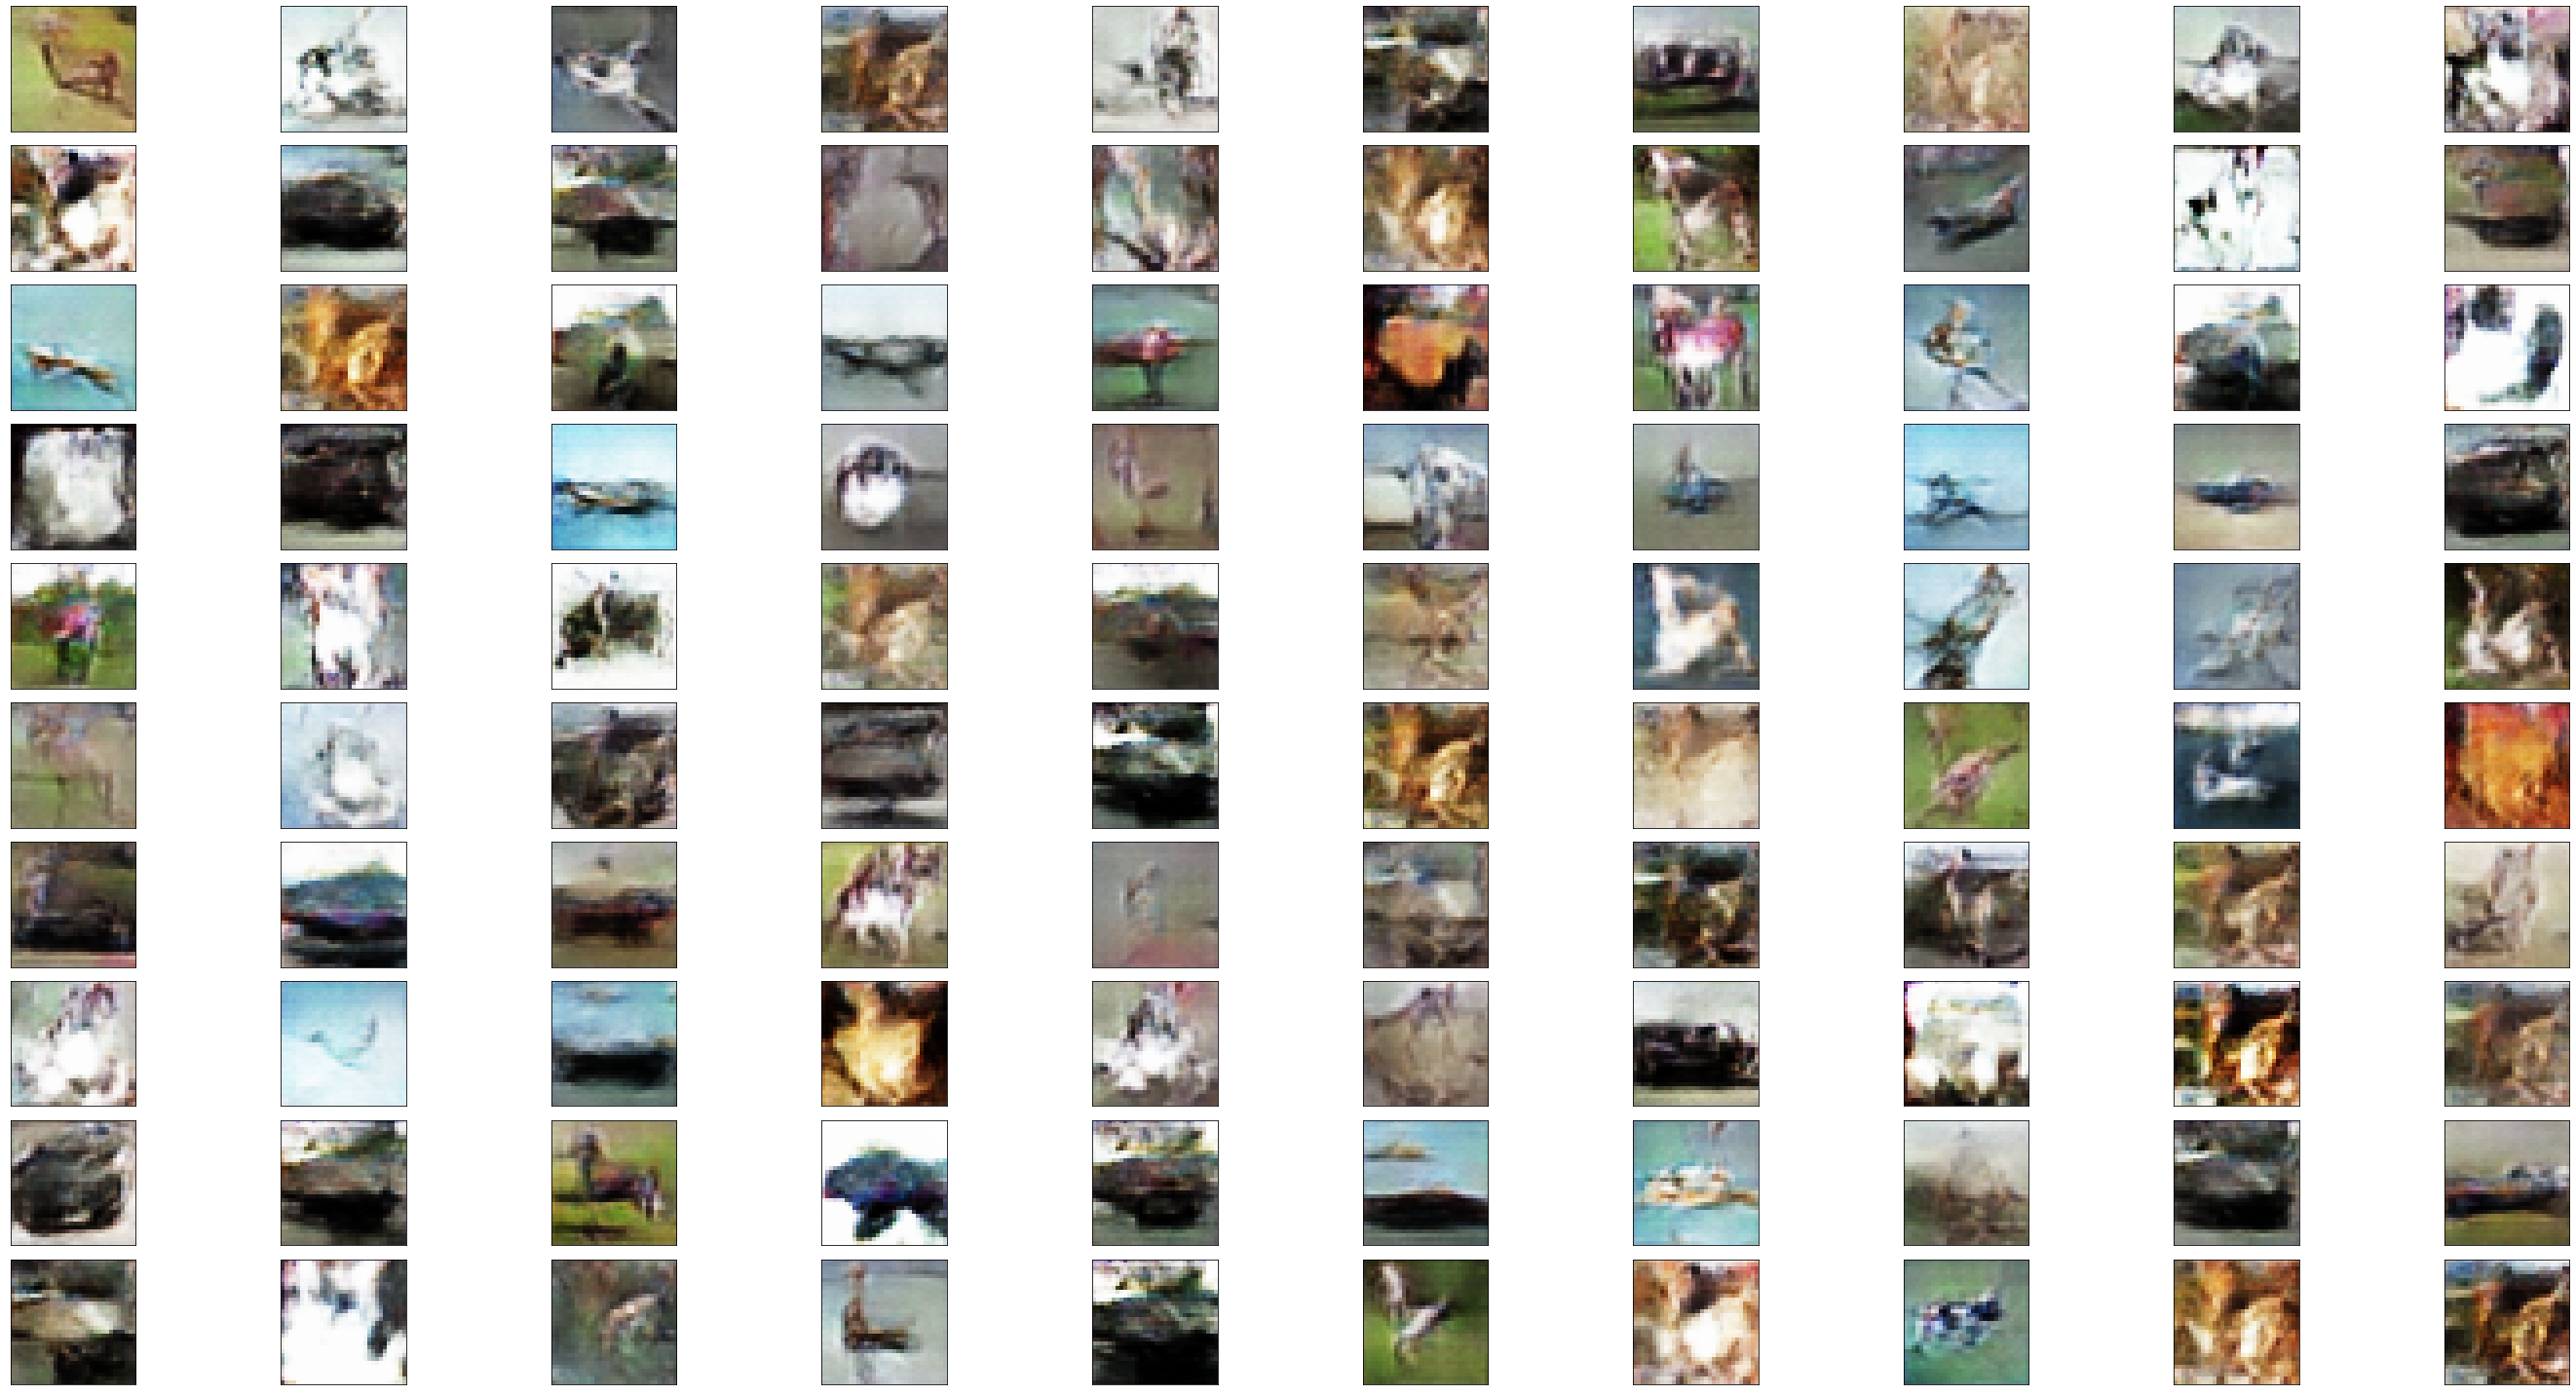

epoch = 22/50, d_loss=0.122, g_loss=6.057                                                                                                     
epoch = 23/50, d_loss=0.031, g_loss=4.839                                                                                                     
epoch = 24/50, d_loss=0.099, g_loss=4.399                                                                                                     
epoch = 25/50, d_loss=0.091, g_loss=4.857                                                                                                     
epoch = 26/50, d_loss=0.390, g_loss=4.227                                                                                                     
epoch = 27/50, d_loss=0.236, g_loss=2.571                                                                                                     
epoch = 28/50, d_loss=0.030, g_loss=4.630                                                                                                     

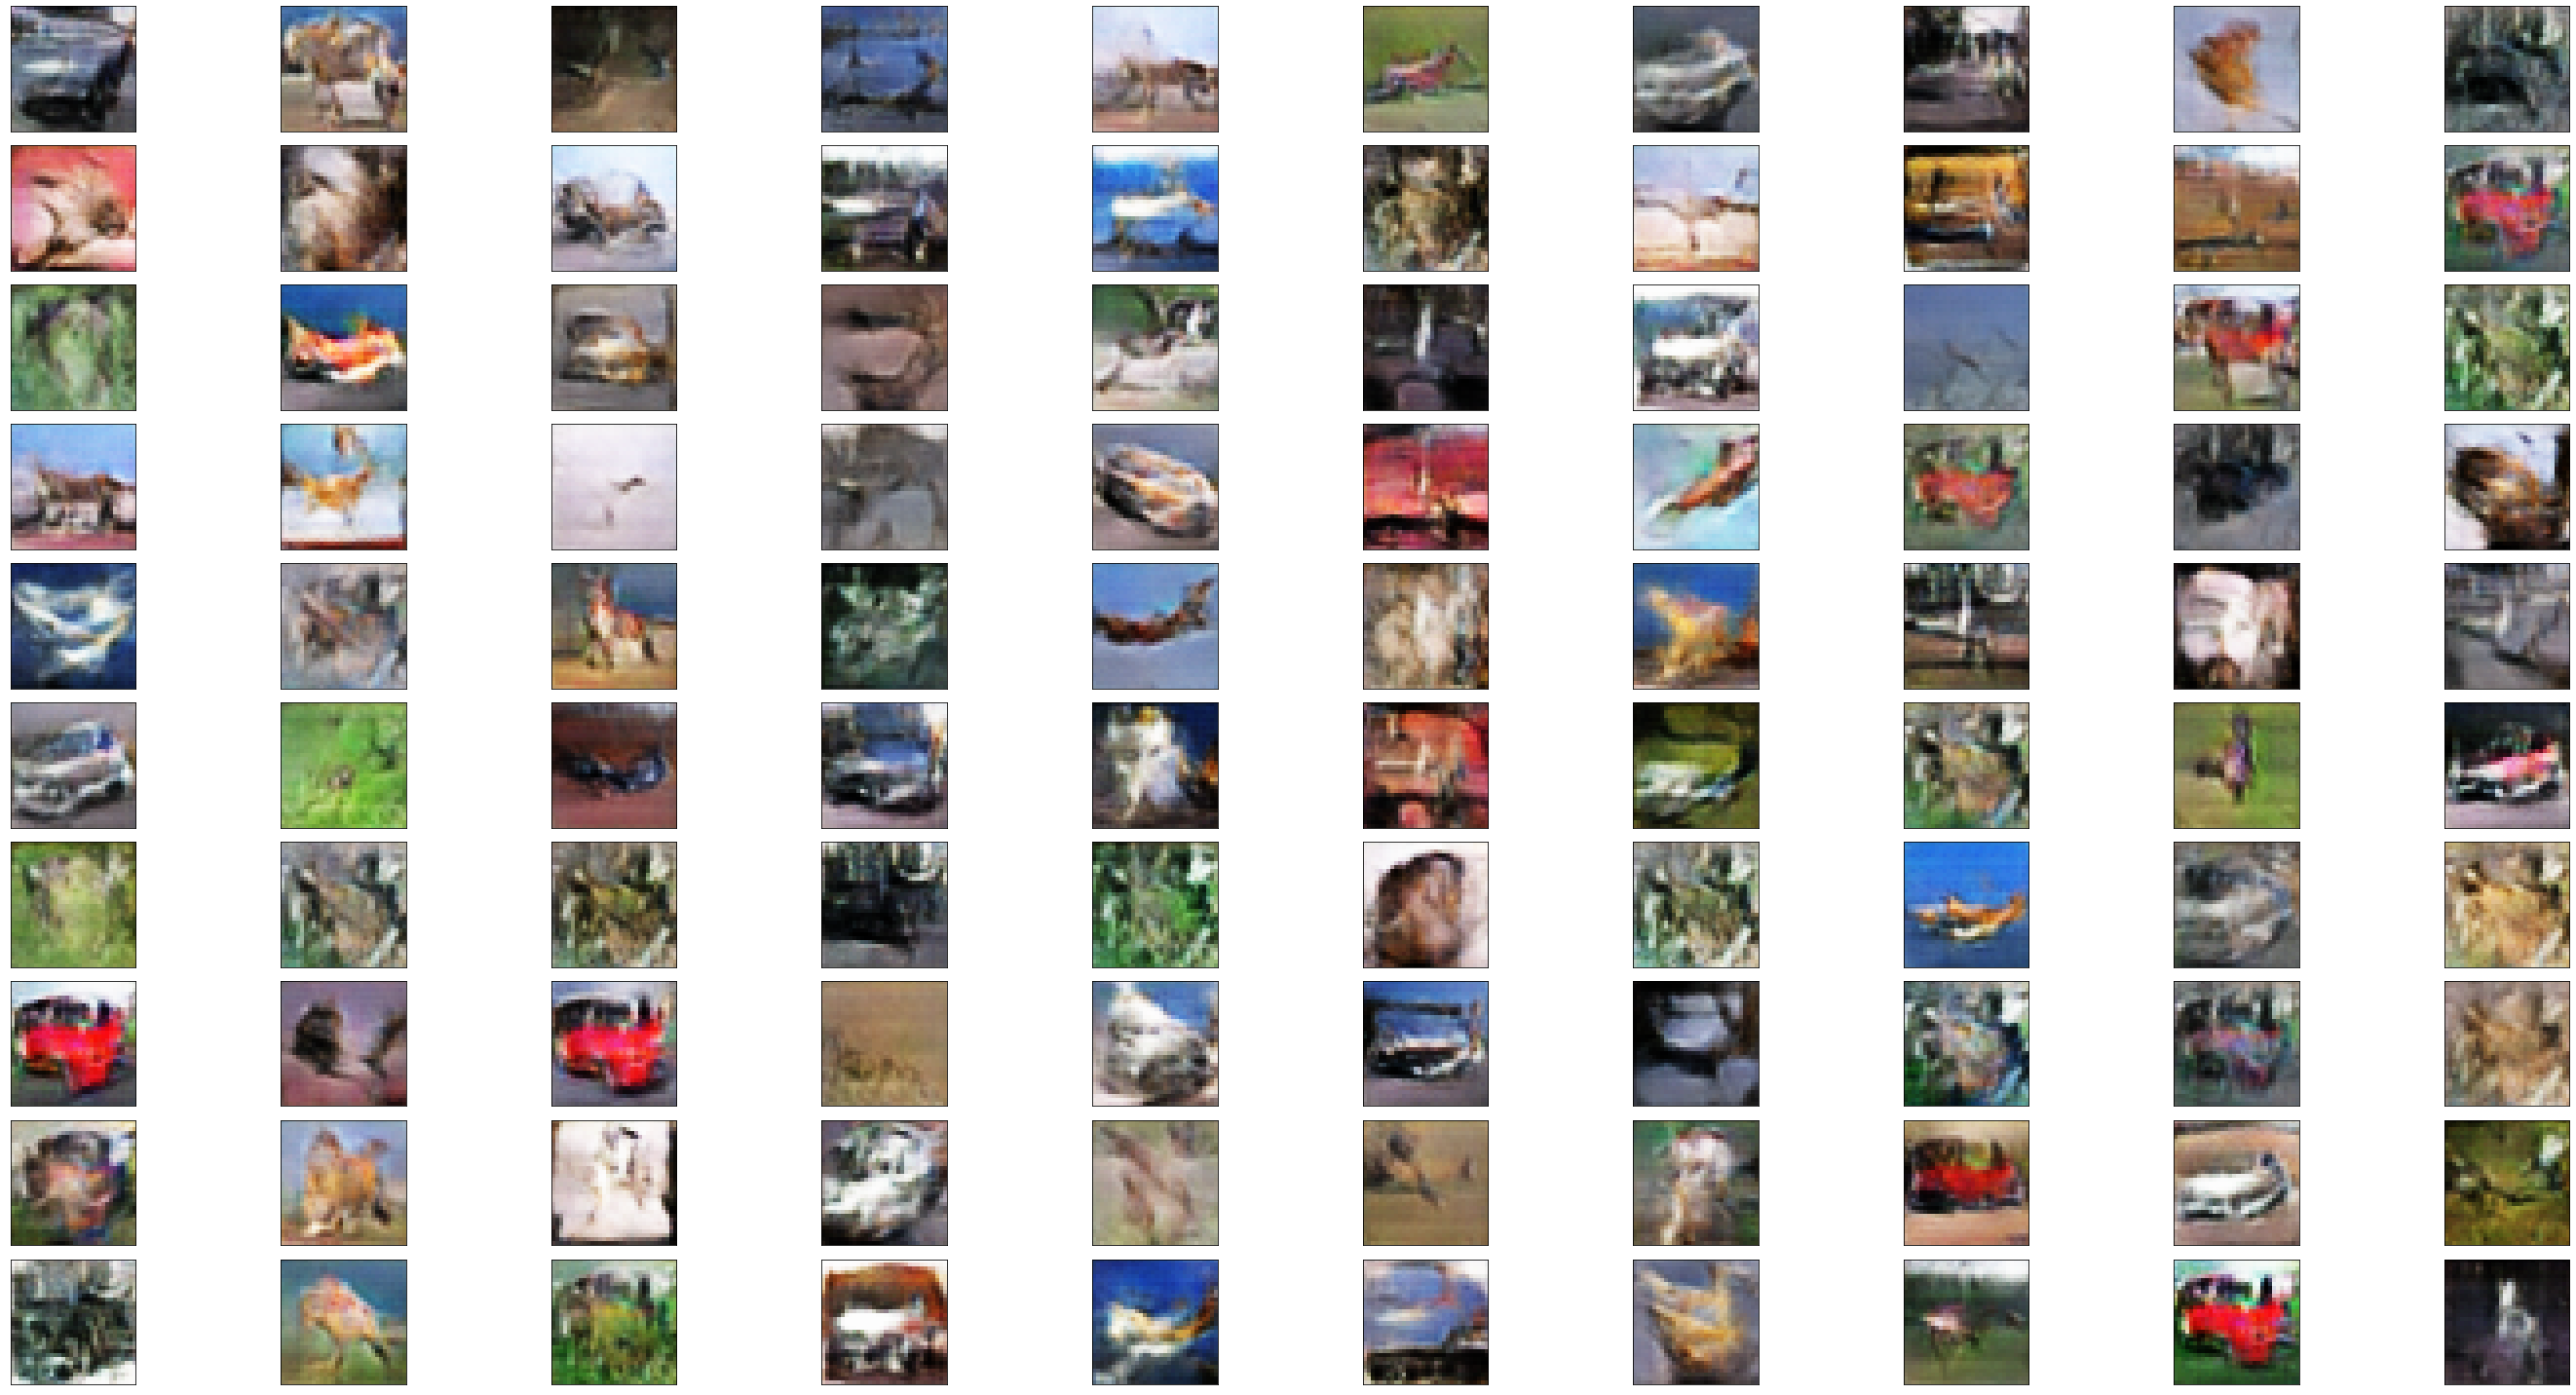

epoch = 32/50, d_loss=0.518, g_loss=3.667                                                                                                     
epoch = 33/50, d_loss=0.104, g_loss=10.269                                                                                                     
epoch = 34/50, d_loss=0.306, g_loss=4.571                                                                                                     
epoch = 35/50, d_loss=0.084, g_loss=11.789                                                                                                     
epoch = 36/50, d_loss=0.103, g_loss=4.194                                                                                                     
epoch = 37/50, d_loss=0.000, g_loss=8.125                                                                                                     
epoch = 38/50, d_loss=0.003, g_loss=5.837                                                                                                   

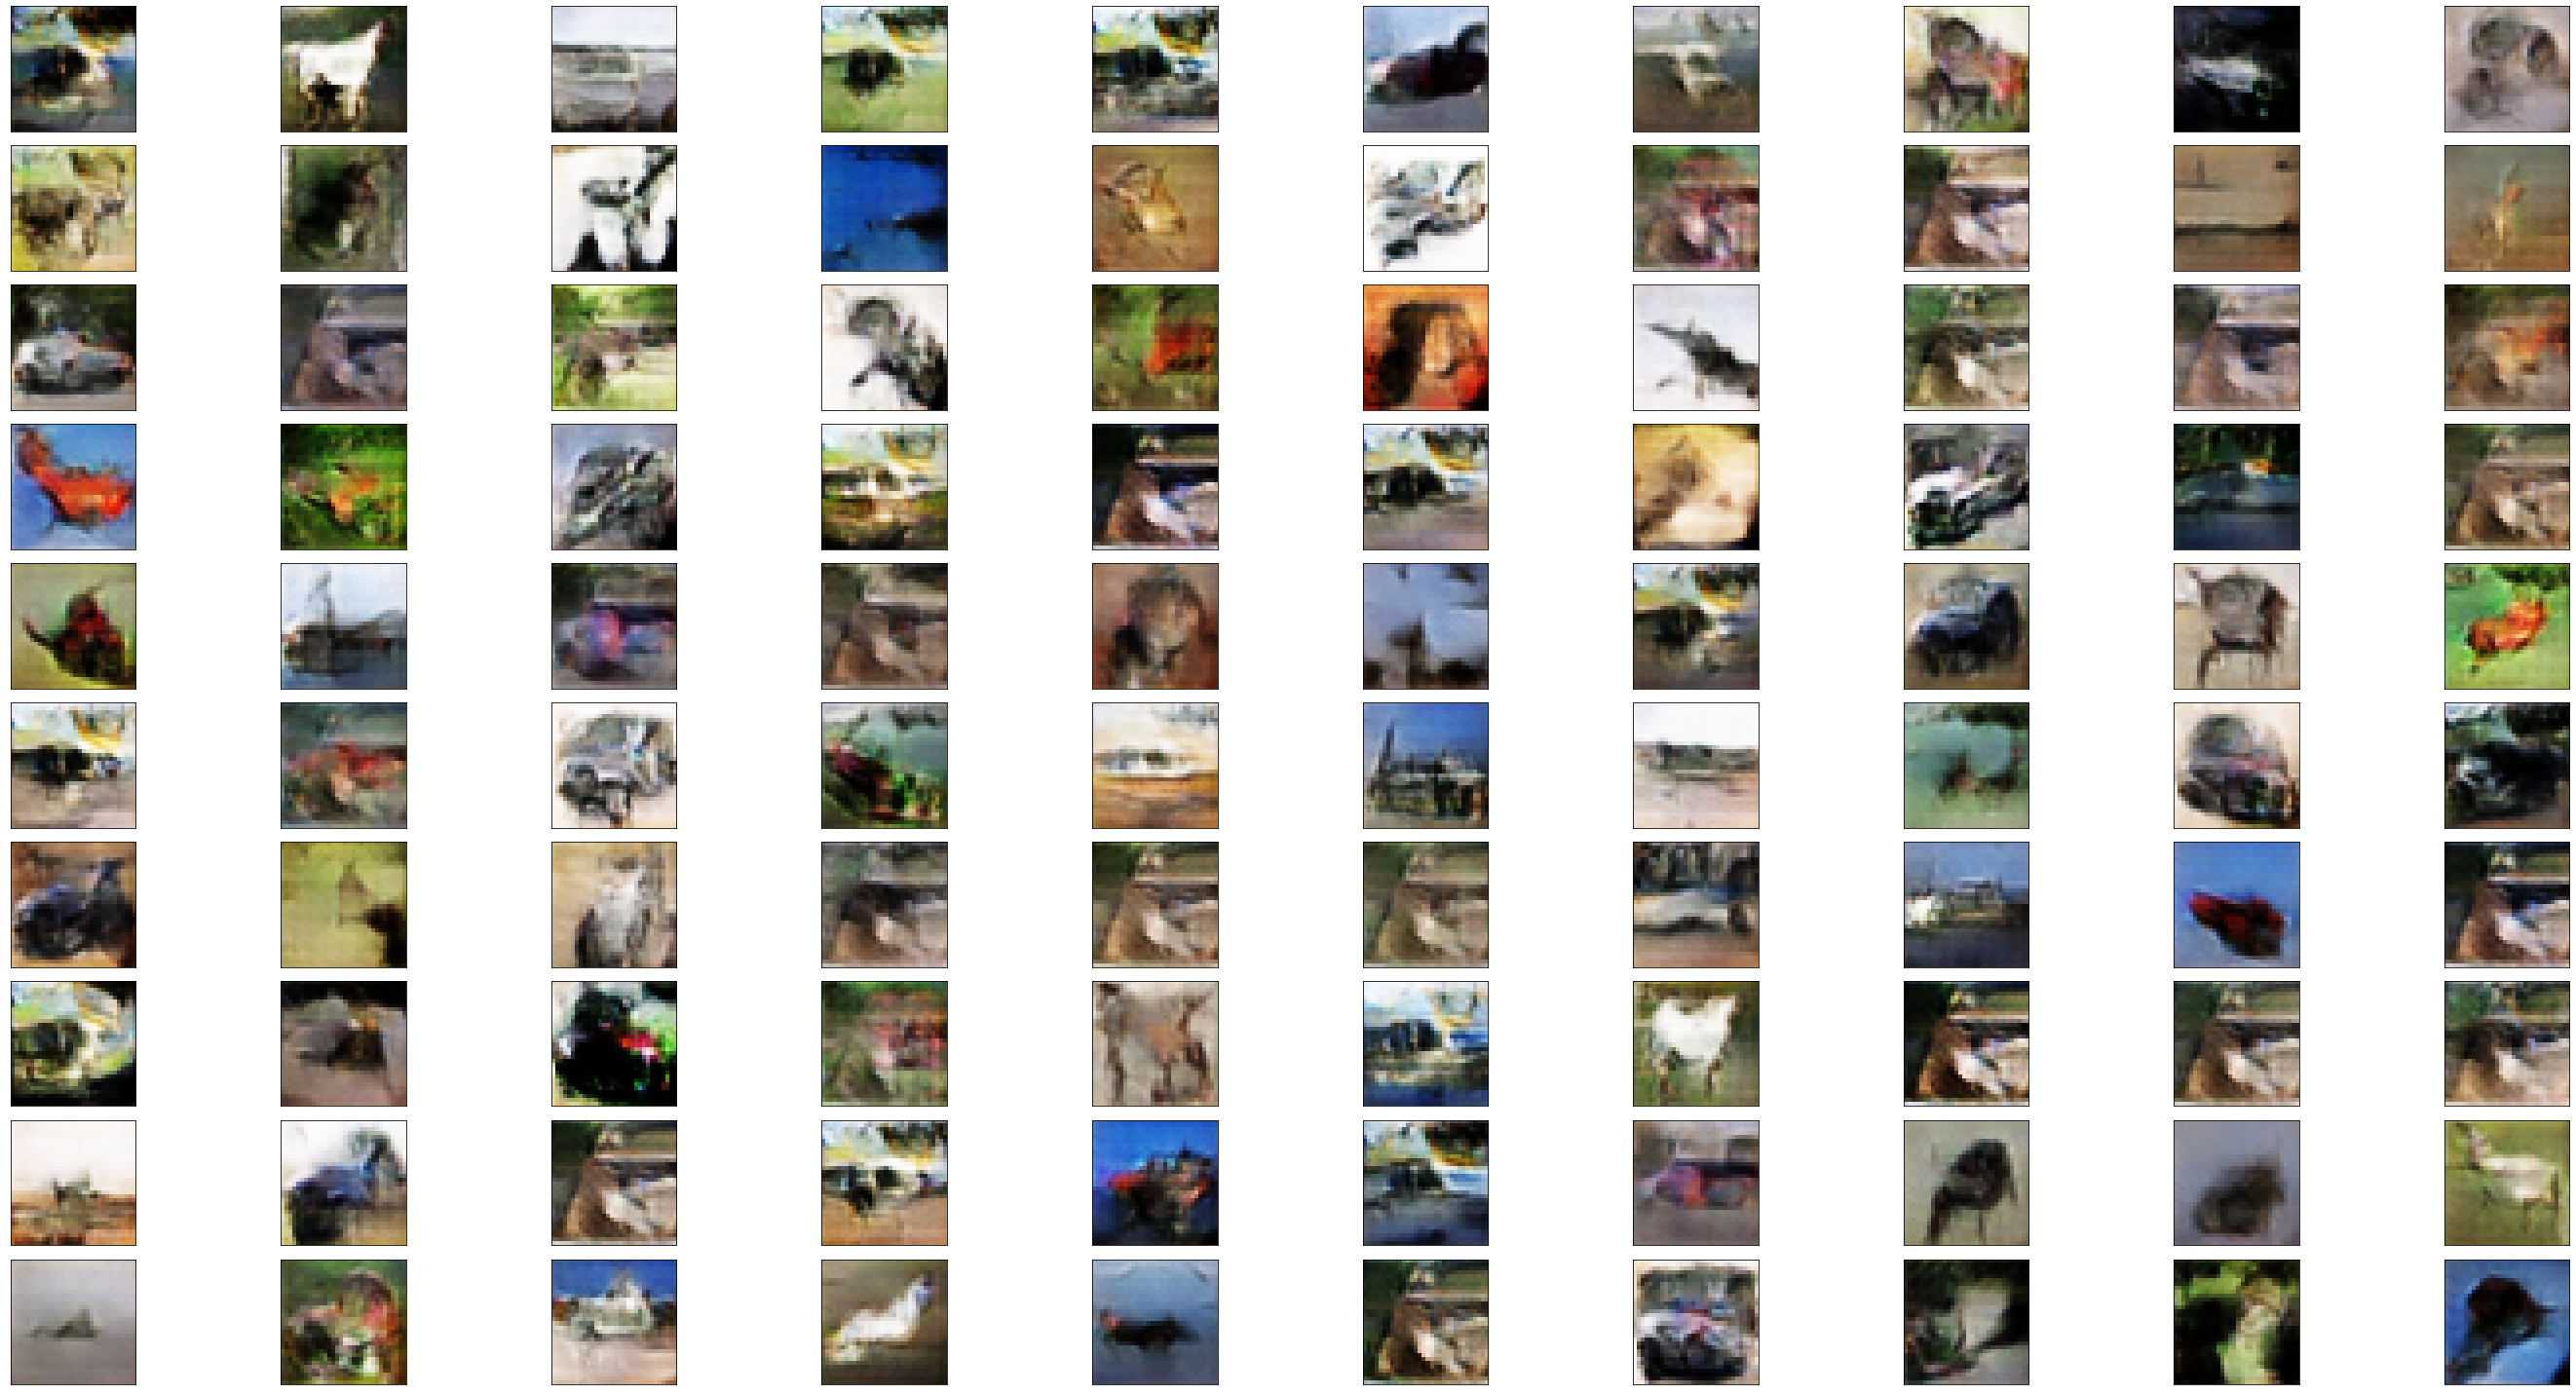

epoch = 42/50, d_loss=1.812, g_loss=16.113                                                                                                     
epoch = 43/50, d_loss=0.302, g_loss=9.855                                                                                                     
epoch = 44/50, d_loss=0.011, g_loss=6.255                                                                                                     
epoch = 45/50, d_loss=0.108, g_loss=6.219                                                                                                     
epoch = 46/50, d_loss=0.068, g_loss=9.087                                                                                                     
epoch = 47/50, d_loss=0.020, g_loss=8.718                                                                                                     
epoch = 48/50, d_loss=0.002, g_loss=7.715                                                                                                    

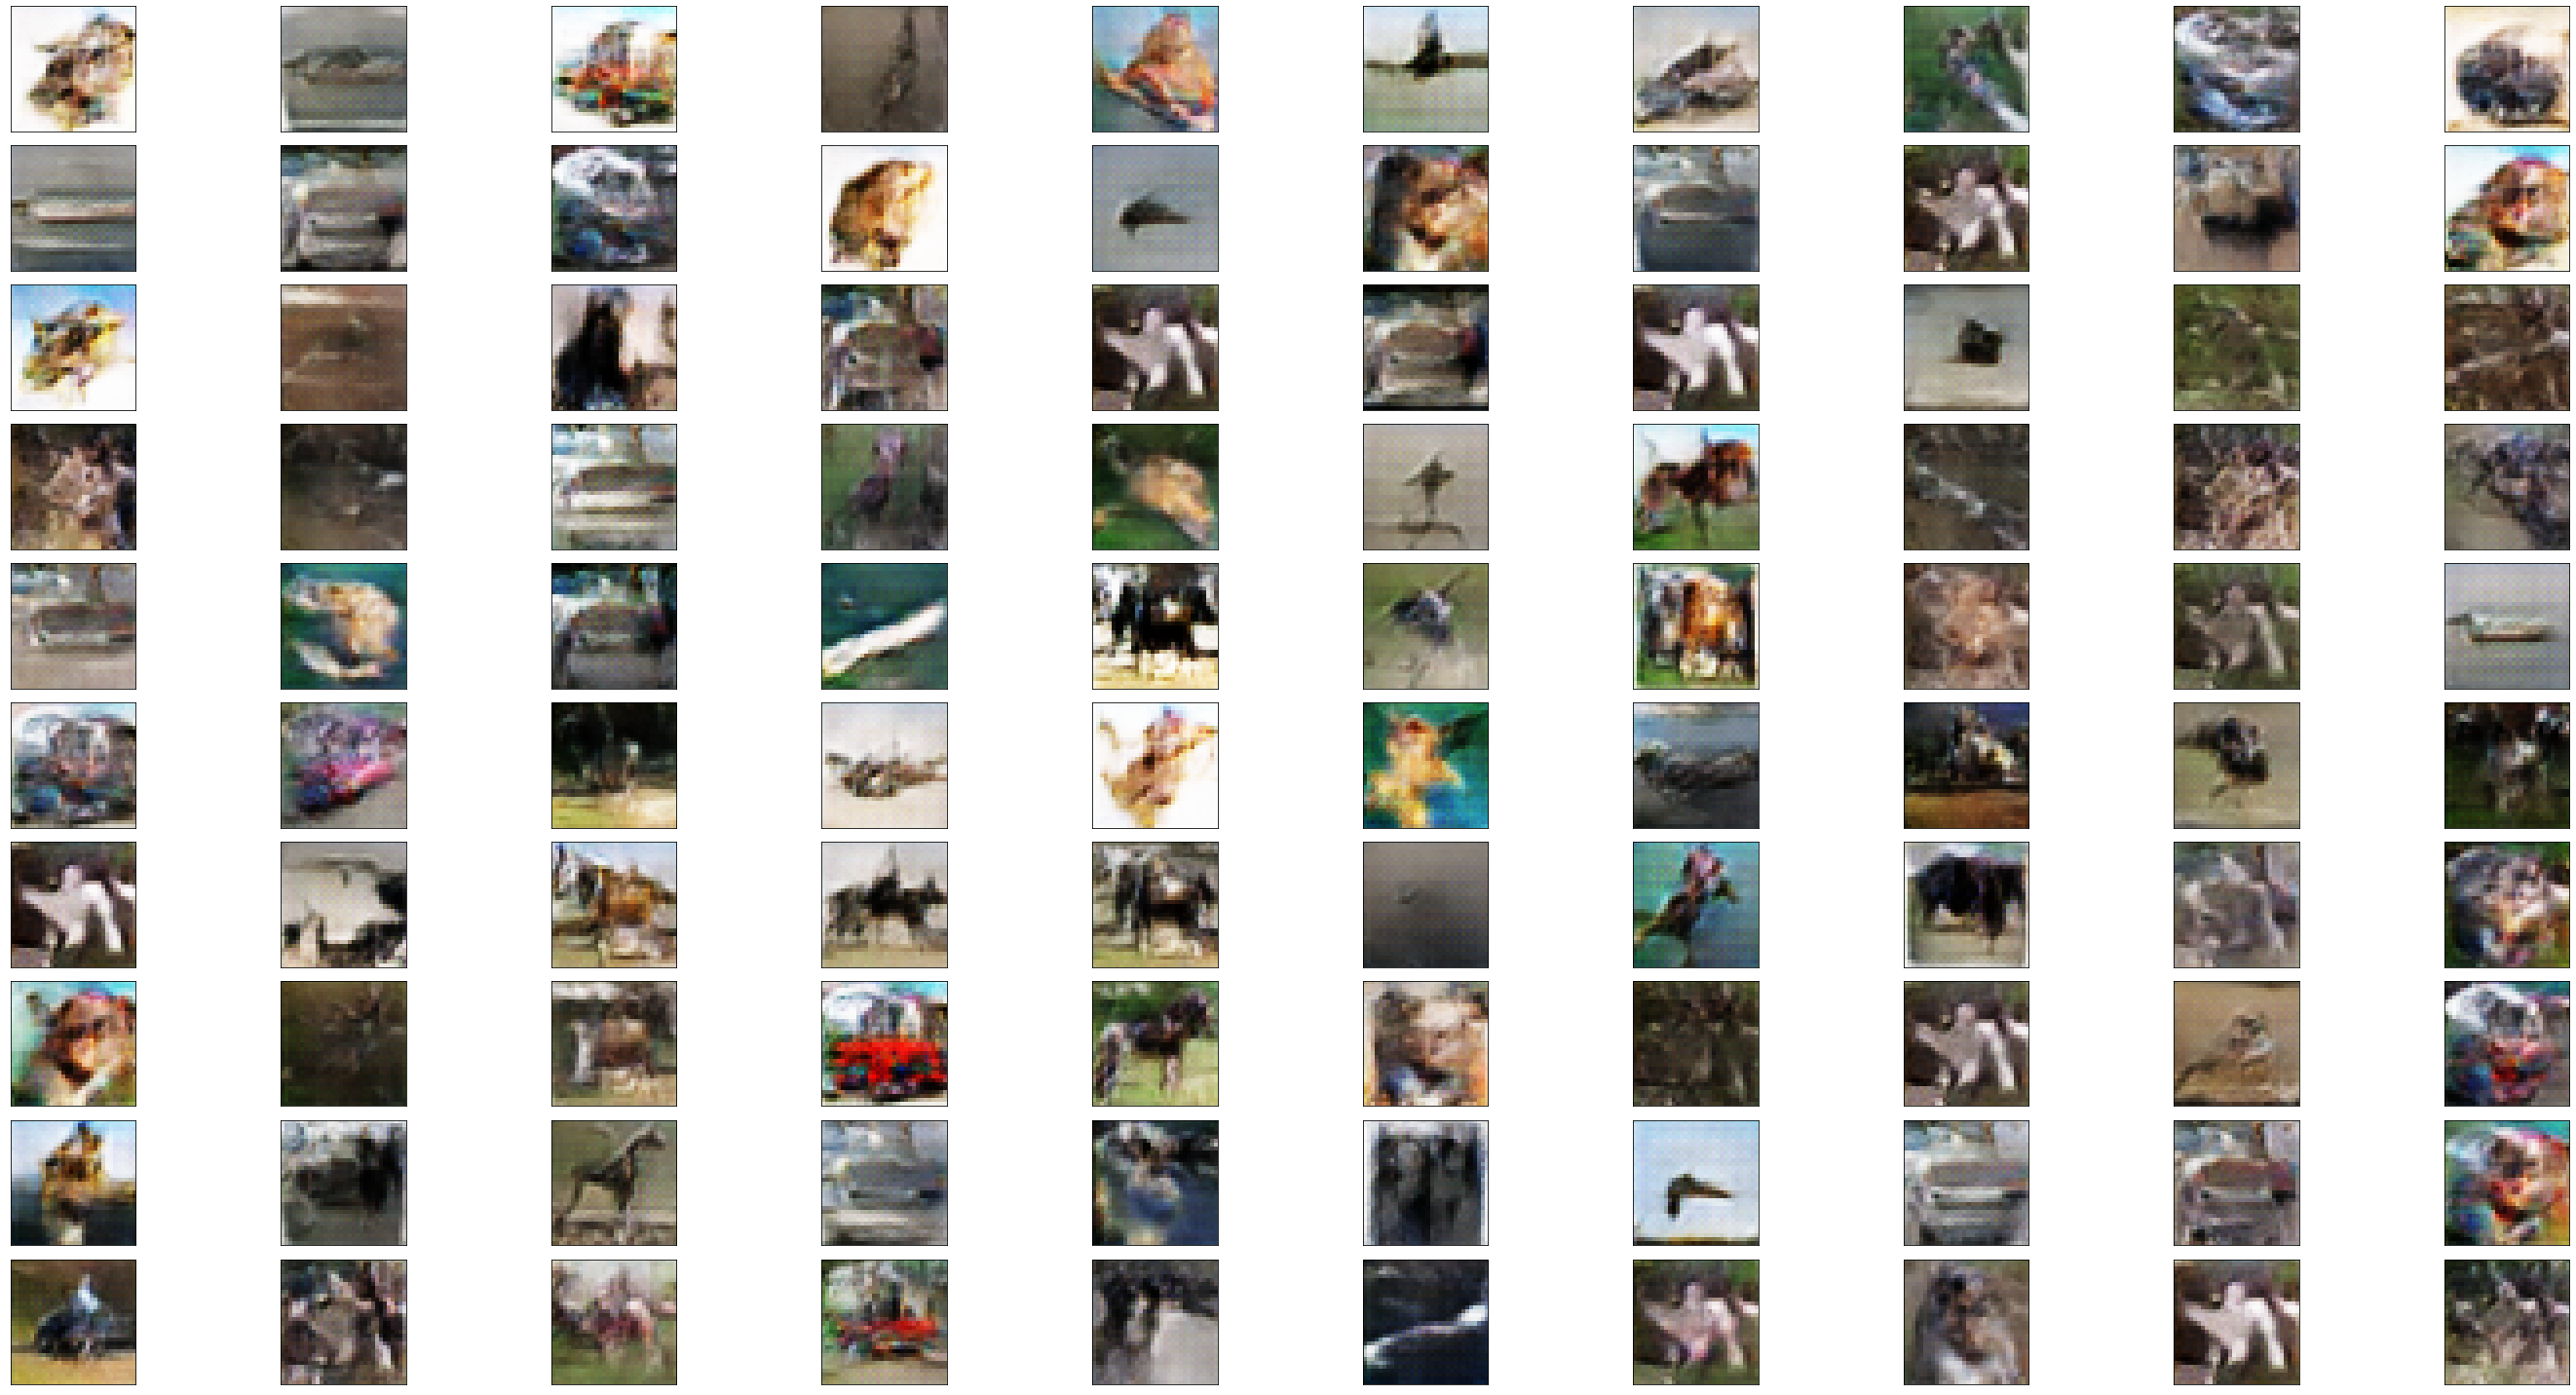

In [ ]:
epochs = 50
batch_size = 32
smooth = 0

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
g_loss = []

d_acc = []
g_acc = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        d_loss_real, d_acc_real= discriminator.train_on_batch(x=X_batch,
                                                   y=real * (1 - smooth))
        
        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        X_fake = generator.predict_on_batch(z)
        d_loss_fake, d_acc_fake= discriminator.train_on_batch(x=X_fake, y=fake)
         
        # Discriminator loss
        #d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        #d_acc_batch = 0.5 * (d_acc_real[1] + d_acc_fake[1])

        d_loss_batch = 0.5 * (d_loss_real + d_loss_fake)
        d_acc_batch = 0.5 * (d_acc_real + d_acc_fake)



        # Train Generator weights
        discriminator.trainable = False
        g_loss_batch, g_acc_batch = d_g.train_on_batch(x=z, y=real)

        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, g_loss_batch),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    g_loss.append(g_loss_batch)
    d_acc.append(d_acc_batch)
    g_acc.append(g_acc_batch)
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], g_loss[-1]), 100*' ')

    if e % 20 == 0:
        samples = 100
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, latent_dim)))
        #img = vis_square(generated_images)
        #plt.figure()
        #plt.imshow(img)
        fig = plt.figure(figsize=(40,20))

        for k in range(samples):
            plt.subplot(10, 10, k + 1, xticks=[], yticks=[])
            plt.imshow(((x_fake[k] + 1)* 127).astype(np.uint8))

        plt.tight_layout()
        plt.show()

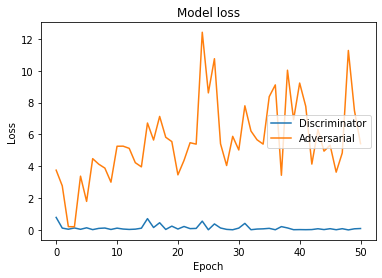

In [ ]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()

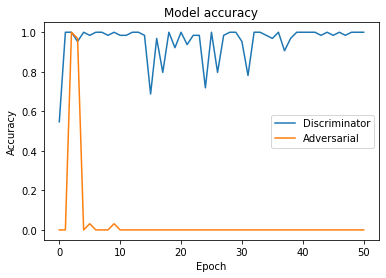

In [ ]:
plt.plot(d_acc)
plt.plot(g_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()